In [4]:
import json
import pandas as pd
from tqdm.auto import tqdm
from sentence_transformers import SentenceTransformer
from elasticsearch import Elasticsearch

# Loading Actual Data

In [5]:
import json

# Update the file path to the JSON file
file_path = "/workspaces/Rag_Project_Pod/Data_prep/final_data.json"

# Load the JSON file into a dictionary
with open(file_path, 'r') as json_file:
    documents = json.load(json_file)

documents[0]


{'Category': 'General Information',
 'Question': 'What is syndicated research?',
 'Answer': 'Syndicated research is a type of market research where data and findings are collected and compiled by a research agency and then sold to multiple clients. It provides insights into consumer behavior, market trends, and product performance across various FMCG categories.',
 'doc_id': '3e72e1c8'}

# Loading Ground Truth Data

In [6]:
import pandas as pd

df_ground_truth = pd.read_csv(r'/workspaces/Rag_Project_Pod/Data_prep/ground_truth_data.csv')
df_ground_truth.head()                              

,Question,Category,Document
0,Can you explain what syndicated research entails?,General Information,3e72e1c8
1,What type of data is included in syndicated re...,General Information,3e72e1c8
2,Who compiles the findings for syndicated resea...,General Information,3e72e1c8
3,In what industries is syndicated research comm...,General Information,3e72e1c8
4,How can syndicated research benefit multiple c...,General Information,3e72e1c8


In [7]:
ground_truth = df_ground_truth.to_dict(orient='records')
ground_truth[0]

{'Question': 'Can you explain what syndicated research entails?',
 'Category': 'General Information',
 'Document': '3e72e1c8'}

In [8]:
doc_idx = {d['doc_id']: d for d in documents}

In [9]:
doc_idx['3e72e1c8']['Answer']

'Syndicated research is a type of market research where data and findings are collected and compiled by a research agency and then sold to multiple clients. It provides insights into consumer behavior, market trends, and product performance across various FMCG categories.'

# Index data


In [10]:
from sentence_transformers import SentenceTransformer


model_name = 'multi-qa-MiniLM-L6-cos-v1'
model = SentenceTransformer(model_name)

/home/codespace/.python/current/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [51]:
from elasticsearch import Elasticsearch

es_client = Elasticsearch('http://localhost:9200') 

index_settings = {
    "settings": {
        "number_of_shards": 1,
        "number_of_replicas": 0
    },
    "mappings": {
        "properties": {
            "Answer": {"type": "text"},
            "Category": {"type": "text"},
            "Question": {"type": "text"},
            "doc_id": {"type": "keyword"},
            "question_vector": {
                "type": "dense_vector",
                "dims": 384,
                "index": True,
                "similarity": "cosine"
            },
            "text_vector": {
                "type": "dense_vector",
                "dims": 384,
                "index": True,
                "similarity": "cosine"
            },
            "question_text_vector": {
                "type": "dense_vector",
                "dims": 384,
                "index": True,
                "similarity": "cosine"
            },
        }
    }
}

index_name = "insights-questions"

es_client.indices.delete(index=index_name, ignore_unavailable=True)
es_client.indices.create(index=index_name, body=index_settings)

ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'insights-questions'})

In [52]:
for doc in tqdm(documents):
    question = doc['Question']
    text = doc['Answer']
    qt = question + ' ' + text

    doc['question_vector'] = model.encode(question)
    doc['text_vector'] = model.encode(text)
    doc['question_text_vector'] = model.encode(qt)

  0%|          | 0/260 [00:00<?, ?it/s]

In [53]:
for doc in tqdm(documents):
    es_client.index(index=index_name, document=doc)

  0%|          | 0/260 [00:00<?, ?it/s]

# Retrieval using Hybrid Search & RRF

In [54]:
def compute_rrf(rank, k=60):
    """ Our own implementation of the relevance score """
    return 1 / (k + rank)

In [55]:
def elastic_search_hybrid_rrf(field, query, vector, k=60):
    # KNN Query
    knn_query = {
        "field": field,
        "query_vector": vector,
        "k": 10,
        "num_candidates": 10000,
        "boost": 0.5
    }

    # Keyword Query
    keyword_query = {
        "bool": {
            "must": {
                "multi_match": {
                    "query": query,
                    "fields": ["Question", "Answer", "Category"],  # Updated fields
                    "type": "best_fields",
                    "boost": 0.5
                }
            }
        }
    }

    # KNN Search
    knn_results = es_client.search(
        index=index_name, 
        body={
            "knn": knn_query, 
            "size": 10
        }
    )['hits']['hits']
    
    # Keyword Search
    keyword_results = es_client.search(
        index=index_name, 
        body={
            "query": keyword_query, 
            "size": 10
        }
    )['hits']['hits']
    
    # Reciprocal Rank Fusion (RRF) scoring
    rrf_scores = {}
    
    # Calculate RRF scores for KNN results
    for rank, hit in enumerate(knn_results):
        doc_id = hit['_id']
        rrf_scores[doc_id] = compute_rrf(rank + 1, k)

    # Calculate RRF scores for keyword results
    for rank, hit in enumerate(keyword_results):
        doc_id = hit['_id']
        if doc_id in rrf_scores:
            rrf_scores[doc_id] += compute_rrf(rank + 1, k)
        else:
            rrf_scores[doc_id] = compute_rrf(rank + 1, k)

    # Sort RRF scores in descending order
    reranked_docs = sorted(rrf_scores.items(), key=lambda x: x[1], reverse=True)
    
    # Get top-K documents by the score
    final_results = []
    for doc_id, score in reranked_docs[:5]:
        doc = es_client.get(index=index_name, id=doc_id)
        final_results.append(doc['_source'])
    
    return final_results


In [56]:
def question_text_hybrid_rrf(q):
    question = q['Question']

    v_q = model.encode(question)

    return elastic_search_hybrid_rrf('question_text_vector', question, v_q)

In [57]:
query = {'Question': "What is the sample size?"}
search_results = question_text_hybrid_rrf(query)
search_results[0]['Answer']

'The consumer panel consists of approximately 10,000 households, representing diverse demographic and geographic segments to ensure the data is reflective of the broader population.'

# The RAG flow


In [18]:
def build_prompt(query, search_results):
    prompt_template = """
You're a syndicated market research provider. Answer the QUESTION based on the CONTEXT from the FAQ database.
Use only the facts from the CONTEXT when answering the QUESTION.

QUESTION: {question}

CONTEXT: 
{context}
""".strip()

    context = ""
    
    for doc in search_results:
        context = context + f"section: {doc['Category']}\nquestion: {doc['Question']}\nanswer: {doc['Answer']}\n\n"
    
    prompt = prompt_template.format(question=query, context=context).strip()
    return prompt

In [19]:
prompt = build_prompt(query['Question'], search_results)
prompt

"You're a syndicated market research provider. Answer the QUESTION based on the CONTEXT from the FAQ database.\nUse only the facts from the CONTEXT when answering the QUESTION.\n\nQUESTION: What is the sample size?\n\nCONTEXT: \nsection: Data Collection Methodology\nquestion: What is the sample size of the consumer panel?\nanswer: The consumer panel consists of approximately 10,000 households, representing diverse demographic and geographic segments to ensure the data is reflective of the broader population.\n\nsection: General Information\nquestion: What is the sample size for global studies?\nanswer: For global studies, the sample size typically includes over 50,000 respondents, ensuring a representative sample across different regions and demographics.\n\nsection: Data Collection Methodology\nquestion: How is household size factored into the research?\nanswer: Household size is factored into the research by segmenting data to understand how family size influences purchase behavior, 

In [36]:

import os
from openai import OpenAI

os.environ['OPENAI_API_KEY'] = 'add your key here'
client = OpenAI()


def llm(prompt, model='gpt-4o-mini'):
    response = client.chat.completions.create(
        model=model,
        messages=[{"role": "user", "content": prompt}]
    )
    
    return response.choices[0].message.content

In [20]:
import os
from groq import Groq



# Initialize the Groq client using the API key
client_groq = Groq(api_key='add your key here')

# Define the function to use Groq's LLM
def llm_groq(prompt, model='llama3-70b-8192'):  # Adjust the model name if needed
    response = client_groq.chat.completions.create(
        model=model,
        messages=[{"role": "user", "content": prompt}]
    )
    
    return response.choices[0].message.content

# Example usage:
result = llm_groq("Explain the importance of fast language models")
print(result)


Fast language models have become increasingly important in natural language processing (NLP) and artificial intelligence (AI) applications, revolutionizing the way we interact with machines and access information. Here are some reasons why fast language models are crucial:

1. **Real-time Interaction**: Fast language models enable real-time interaction with applications, making them more responsive and engaging. This is particularly important for chatbots, voice assistants, and other conversational AI systems that require quick responses to user inputs.
2. **Efficient Processing**: Fast language models reduce the computational resources required to process language inputs, making them more energy-efficient and allowing them to be deployed on smaller devices or in resource-constrained environments.
3. **Improved User Experience**: Faster response times and more accurate results lead to a better user experience, increasing user satisfaction and adoption rates for AI-powered applications.

In [21]:
def rag(query: dict, model='gpt-4o-mini') -> str:
    search_results = question_text_hybrid_rrf(query)
    prompt = build_prompt(query['Question'], search_results)
    answer = llm(prompt, model=model)
    return answer

In [25]:
def rag_groq(query: dict, model='llama3-8b-8192') -> str:
    search_results = question_text_hybrid_rrf(query)
    prompt = build_prompt(query['Question'], search_results)
    answer = llm_groq(prompt, model=model)
    return answer

In [30]:
ground_truth[6]

{'Question': 'Are quarterly summaries included with the monthly updates?',
 'Category': 'General Information',
 'Document': '7a6f8a30'}

In [38]:
rag(ground_truth[6])

'Yes, quarterly summaries are available along with the monthly updates.'

In [26]:
rag_groq(ground_truth[6])

'Based on the context, yes, quarterly summaries are included with the monthly updates. The question "How often is the data updated?" mentions that quarterly and annual summaries are available in addition to the monthly updates.'

In [32]:
doc_idx['7a6f8a30']['Answer']

'The data is typically updated on a monthly basis, with quarterly and annual summaries available. Real-time or weekly updates may also be available depending on the subscription level.'

# Cosine similarity metric


# Eval gpt 4o mini

In [39]:
ground_truth[0]

{'Question': 'Can you explain what syndicated research entails?',
 'Category': 'General Information',
 'Document': '3e72e1c8'}

In [40]:
len(ground_truth)

1300

In [41]:
answers = {}

for i, rec in enumerate(tqdm(ground_truth)):
    if i in answers:
        continue

    answer_llm = rag(rec)
    doc_id = rec['Document']
    original_doc = doc_idx[doc_id]
    answer_orig = original_doc['Answer']

    answers[i] = {
        'answer_llm': answer_llm,
        'answer_orig': answer_orig,
        'document': doc_id,
        'question': rec['Question'],
        'category': rec['Category'],
    }

  0%|          | 0/1300 [00:00<?, ?it/s]

In [43]:
import json

# Save answers periodically to a file
def save_answers_to_file(filename, data):
    with open(filename, 'w') as f:
        json.dump(data, f)

# Load answers from a file (to resume progress)
def load_answers_from_file(filename):
    try:
        with open(filename, 'r') as f:
            return json.load(f)
    except FileNotFoundError:
        return {}


In [44]:
save_answers_to_file('answers_gpt-4-mini.json', answers)

In [ ]:

# Load answers if restarting
answers = load_answers_from_file('answers_gpt-4-mini.json')

for i, rec in enumerate(tqdm(ground_truth)):
    if i in answers:
        continue

    answer_llm = rag(rec)
    doc_id = rec['Document']
    original_doc = doc_idx[doc_id]
    answer_orig = original_doc['Answer']

    answers[i] = {
        'answer_llm': answer_llm,
        'answer_orig': answer_orig,
        'document': doc_id,
        'question': rec['Question'],
        'category': rec['Category'],
    }

    # Periodically save the answers (e.g., every 100 iterations)
    if i % 100 == 0:
        save_answers_to_file('answers_gpt-4-mini.json', answers)


In [50]:
results_gpt4o_mini = [None] * len(ground_truth)

for i, val in answers.items():
    results_gpt4o_mini[i] = val.copy()
    results_gpt4o_mini[i].update(ground_truth[i])

In [52]:
df_gpt_4o_mini = pd.DataFrame(results_gpt4o_mini)
df_gpt_4o_mini.head()

,answer_llm,answer_orig,document,question,category,Question,Category,Document
0,Syndicated research is a type of market resear...,Syndicated research is a type of market resear...,3e72e1c8,Can you explain what syndicated research entails?,General Information,Can you explain what syndicated research entails?,General Information,3e72e1c8
1,Syndicated research includes data and findings...,Syndicated research is a type of market resear...,3e72e1c8,What type of data is included in syndicated re...,General Information,What type of data is included in syndicated re...,General Information,3e72e1c8
2,The findings for syndicated research are compi...,Syndicated research is a type of market resear...,3e72e1c8,Who compiles the findings for syndicated resea...,General Information,Who compiles the findings for syndicated resea...,General Information,3e72e1c8
3,Syndicated research is commonly used in the fo...,Syndicated research is a type of market resear...,3e72e1c8,In what industries is syndicated research comm...,General Information,In what industries is syndicated research comm...,General Information,3e72e1c8
4,Syndicated research benefits multiple clients ...,Syndicated research is a type of market resear...,3e72e1c8,How can syndicated research benefit multiple c...,General Information,How can syndicated research benefit multiple c...,General Information,3e72e1c8


In [53]:
df_gpt_4o_mini.to_csv('/workspaces/Rag_Project_Pod/Evaluation/LLM Evaluation/llm_data/results_gpt4o_mini.csv', index=False)

In [54]:
results_gpt4o_mini = df_gpt_4o_mini.to_dict(orient='records')

In [60]:
record = results_gpt4o_mini[0]
record['answer_llm']

'Syndicated research is a type of market research where data and findings are collected and compiled by a research agency and then sold to multiple clients. It provides insights into consumer behavior, market trends, and product performance across various fast-moving consumer goods (FMCG) categories. This research is standardized and offers broad insights, distinguishing it from custom research, which is tailored to the specific needs of an individual client.'

In [34]:
def compute_similarity(record):
    answer_orig = record['answer_orig']
    answer_llm = record['answer_llm']
    
    v_llm = model.encode(answer_llm)
    v_orig = model.encode(answer_orig)
    
    return v_llm.dot(v_orig)

In [62]:
compute_similarity(record)

0.9748598

In [63]:
similarity = []

for record in tqdm(results_gpt4o_mini):
    sim = compute_similarity(record)
    similarity.append(sim)

  0%|          | 0/1300 [00:00<?, ?it/s]

In [64]:
df_gpt_4o_mini['cosine'] = similarity
df_gpt_4o_mini['cosine'].describe()

count    1300.000000
mean        0.773590
std         0.133313
min         0.270368
25%         0.693528
50%         0.790323
75%         0.874569
max         1.000000
Name: cosine, dtype: float64

In [70]:
df_gpt_4o_mini.to_csv('/workspaces/Rag_Project_Pod/Evaluation/LLM Evaluation/llm_data/results-gpt4o-mini-cosine.csv', index=False)

# Eval gpt 3.5

In [72]:
def process_record_35(rec):
    model = 'gpt-3.5-turbo'
    answer_llm = rag(rec, model=model)
    
    doc_id = rec['Document']  
    original_doc = doc_idx[doc_id]
    answer_orig = original_doc['Answer']  

    return {
        'answer_llm': answer_llm,
        'answer_orig': answer_orig,
        'document': doc_id,
        'question': rec['Question'],
        'category': rec['Category'],  
    }


In [73]:
process_record_35(ground_truth[36])

{'answer_llm': 'Primary differences in insights offered by syndicated research and custom research are that syndicated research provides broad insights into consumer behavior, market trends, and product performance across various categories, while custom research delivers specific answers to particular business questions tailored to the specific needs of one client.',
 'answer_orig': 'Syndicated research is standardized and sold to multiple clients, while custom research is tailored to the specific needs of one client. Syndicated research provides broad insights, whereas custom research delivers specific answers to particular business questions.',
 'document': '10d86de2',
 'question': 'Can you explain the primary differences in insights offered by syndicated research and custom research?',
 'category': 'General Information'}

In [74]:
results_gpt35  = []

for record in tqdm(ground_truth):
    result = process_record_35(record)
    results_gpt35.append(result)

  0%|          | 0/1300 [00:00<?, ?it/s]

In [77]:
df_gpt35 = pd.DataFrame(results_gpt35)
df_gpt35.to_csv('/workspaces/Rag_Project_Pod/Evaluation/LLM Evaluation/llm_data/results_gpt35.csv', index=False)

In [78]:
results_gpt35 = df_gpt35.to_dict(orient='records')

similarity_35 = []

for record in tqdm(results_gpt35):
    sim = compute_similarity(record)
    similarity_35.append(sim)

  0%|          | 0/1300 [00:00<?, ?it/s]

In [79]:
df_gpt35['cosine'] = similarity_35
df_gpt35['cosine'].describe()

count    1300.000000
mean        0.773680
std         0.152885
min         0.207261
25%         0.676118
50%         0.794979
75%         0.890817
max         1.000000
Name: cosine, dtype: float64

In [81]:
df_gpt35.to_csv('/workspaces/Rag_Project_Pod/Evaluation/LLM Evaluation/llm_data/results-gpt35-cosine.csv', index=False)

# Eval gpt 4o

In [80]:
def process_record_4o(rec):
    model = 'gpt-4o'
    answer_llm = rag(rec, model=model)
    
    doc_id = rec['Document']  
    original_doc = doc_idx[doc_id]
    answer_orig = original_doc['Answer']  

    return {
        'answer_llm': answer_llm,
        'answer_orig': answer_orig,
        'document': doc_id,
        'question': rec['Question'],
        'category': rec['Category'],  
    }


In [82]:
process_record_4o(ground_truth[36])

{'answer_llm': 'The primary differences in insights offered by syndicated research and custom research are:\n\n- **Syndicated Research**: This type of research is standardized and sold to multiple clients. It provides broad, general insights into consumer behavior, market trends, and product performance across various categories. The data and findings are collected and compiled by a research agency, making it suitable for businesses that want a wide-ranging understanding of market dynamics.\n\n- **Custom Research**: This type of research is tailored to the specific needs of one client. It delivers specific answers to particular business questions, offering targeted insights that address unique challenges or objectives. Custom research is ideal for businesses that require in-depth, personalized insights to inform their specific strategic decisions.',
 'answer_orig': 'Syndicated research is standardized and sold to multiple clients, while custom research is tailored to the specific needs

In [83]:
results_gpt4o  = []

for record in tqdm(ground_truth):
    result = process_record_4o(record)
    results_gpt4o.append(result)

  0%|          | 0/1300 [00:00<?, ?it/s]

In [84]:
df_gpt4o = pd.DataFrame(results_gpt4o)
df_gpt4o.to_csv('/workspaces/Rag_Project_Pod/Evaluation/LLM Evaluation/llm_data/results_gpt4o.csv', index=False)

In [85]:
results_gpt4o = df_gpt4o.to_dict(orient='records')

similarity_4o = []

for record in tqdm(results_gpt4o):
    sim = compute_similarity(record)
    similarity_4o.append(sim)

  0%|          | 0/1300 [00:00<?, ?it/s]

In [86]:
df_gpt4o['cosine'] = similarity_4o
df_gpt4o['cosine'].describe()

count    1300.000000
mean        0.770313
std         0.136325
min         0.220222
25%         0.684217
50%         0.790879
75%         0.872769
max         1.000000
Name: cosine, dtype: float64

In [88]:
df_gpt4o.to_csv('/workspaces/Rag_Project_Pod/Evaluation/LLM Evaluation/llm_data/results-gpt4o-cosine.csv', index=False)

### Eval LLama 8b Model

In [28]:
def process_record_llama8b(rec):
    model = 'llama3-8b-8192'
    answer_llm = rag_groq(rec, model=model)
    
    doc_id = rec['Document']  
    original_doc = doc_idx[doc_id]
    answer_orig = original_doc['Answer']  

    return {
        'answer_llm': answer_llm,
        'answer_orig': answer_orig,
        'document': doc_id,
        'question': rec['Question'],
        'category': rec['Category'],  
    }


In [29]:
process_record_llama8b(ground_truth[36])

{'answer_llm': 'Based on the context, the primary differences in insights offered by syndicated research and custom research are:\n\n* Syndicated research provides broad insights into consumer behavior, market trends, and product performance across various FMCG categories, whereas custom research delivers specific answers to particular business questions.\n* Syndicated research is standardized and sold to multiple clients, offering a broad view of the market, whereas custom research is tailored to the specific needs of one client, providing targeted solutions.',
 'answer_orig': 'Syndicated research is standardized and sold to multiple clients, while custom research is tailored to the specific needs of one client. Syndicated research provides broad insights, whereas custom research delivers specific answers to particular business questions.',
 'document': '10d86de2',
 'question': 'Can you explain the primary differences in insights offered by syndicated research and custom research?',
 

In [30]:
results_llama8b  = []

for record in tqdm(ground_truth):
    result = process_record_llama8b(record)
    results_llama8b.append(result)

  0%|          | 0/1300 [00:00<?, ?it/s]

In [32]:
df_llama8b = pd.DataFrame(results_llama8b)
df_llama8b.to_csv('/workspaces/Rag_Project_Pod/Evaluation/LLM Evaluation/llm_data/results_llama8b.csv', index=False)

In [35]:
results_llama8b = df_llama8b.to_dict(orient='records')

similarity_8b = []

for record in tqdm(results_llama8b):
    sim = compute_similarity(record)
    similarity_8b.append(sim)

  0%|          | 0/1300 [00:00<?, ?it/s]

In [36]:
df_llama8b['cosine'] = similarity_8b
df_llama8b['cosine'].describe()

count    1300.000000
mean        0.734798
std         0.124470
min         0.231048
25%         0.659363
50%         0.751954
75%         0.826496
max         0.988872
Name: cosine, dtype: float64

In [37]:
df_llama8b.to_csv('/workspaces/Rag_Project_Pod/Evaluation/LLM Evaluation/llm_data/results-llama8b-cosine.csv', index=False)

### Eval LLama 70b Model

In [49]:
def process_record_llama70b(rec):
    model = 'llama3-70b-8192'
    answer_llm = rag_groq(rec, model=model)
    
    doc_id = rec['Document']  
    original_doc = doc_idx[doc_id]
    answer_orig = original_doc['Answer']  

    return {
        'answer_llm': answer_llm,
        'answer_orig': answer_orig,
        'document': doc_id,
        'question': rec['Question'],
        'category': rec['Category'],  
    }


In [43]:
process_record_llama70b(ground_truth[36])

{'answer_llm': 'According to our FAQ database, the primary differences in insights offered by syndicated research and custom research are:\n\nSyndicated research provides broad insights into consumer behavior, market trends, and product performance across various FMCG categories, whereas custom research delivers specific answers to particular business questions tailored to the specific needs of one client.',
 'answer_orig': 'Syndicated research is standardized and sold to multiple clients, while custom research is tailored to the specific needs of one client. Syndicated research provides broad insights, whereas custom research delivers specific answers to particular business questions.',
 'document': '10d86de2',
 'question': 'Can you explain the primary differences in insights offered by syndicated research and custom research?',
 'category': 'General Information'}

In [44]:
results_llama70b  = []

for record in tqdm(ground_truth):
    result = process_record_llama70b(record)
    results_llama70b.append(result)

  0%|          | 0/1300 [00:00<?, ?it/s]

ConnectionError: Connection error caused by: ConnectionError(Connection error caused by: ProtocolError(('Connection aborted.', ConnectionResetError(104, 'Connection reset by peer'))))

In [58]:
processed_record_count = len(results_llama70b)
remaining_records = ground_truth[processed_record_count:]

# Process only remaining records
for record in tqdm(remaining_records, desc="Processing Remaining Records"):
    result = process_record_llama70b(record)
    results_llama70b.append(result)

Processing Remaining Records:   0%|          | 0/60 [00:00<?, ?it/s]

In [59]:
df_llama70b = pd.DataFrame(results_llama70b)
df_llama70b.to_csv('/workspaces/Rag_Project_Pod/Evaluation/LLM Evaluation/llm_data/results_llama70b.csv', index=False)

In [60]:
results_llama70b = df_llama70b.to_dict(orient='records')

similarity_70b = []

for record in tqdm(results_llama70b):
    sim = compute_similarity(record)
    similarity_70b.append(sim)

  0%|          | 0/1300 [00:00<?, ?it/s]

In [61]:
df_llama70b['cosine'] = similarity_70b
df_llama70b['cosine'].describe()

count    1300.000000
mean        0.738416
std         0.132759
min         0.270034
25%         0.650498
50%         0.757077
75%         0.839946
max         1.000000
Name: cosine, dtype: float64

In [62]:
df_llama70b.to_csv('/workspaces/Rag_Project_Pod/Evaluation/LLM Evaluation/llm_data/results-llama70b-cosine.csv', index=False)

In [63]:
df_gpt_4o_mini = pd.read_csv(r'/workspaces/Rag_Project_Pod/Evaluation/LLM Evaluation/llm_data/results-gpt4o-mini-cosine.csv')
df_gpt4o = pd.read_csv(r'/workspaces/Rag_Project_Pod/Evaluation/LLM Evaluation/llm_data/results-gpt4o-cosine.csv')
df_gpt35 = pd.read_csv(r'/workspaces/Rag_Project_Pod/Evaluation/LLM Evaluation/llm_data/results-gpt35-cosine.csv')
df_llama8b = pd.read_csv(r'/workspaces/Rag_Project_Pod/Evaluation/LLM Evaluation/llm_data/results-llama8b-cosine.csv')
df_llama70b = pd.read_csv(r'/workspaces/Rag_Project_Pod/Evaluation/LLM Evaluation/llm_data/results-llama70b-cosine.csv')



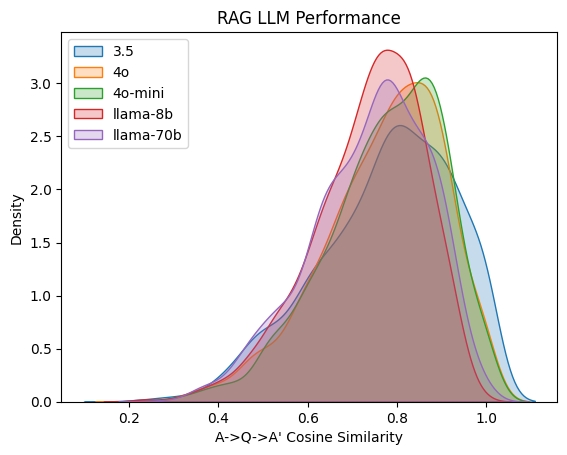

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.kdeplot(df_gpt35['cosine'], label='3.5', fill=True)
sns.kdeplot(df_gpt4o['cosine'], label='4o', fill=True)
sns.kdeplot(df_gpt_4o_mini['cosine'], label='4o-mini', fill=True)
sns.kdeplot(df_llama8b['cosine'], label='llama-8b', fill=True)
sns.kdeplot(df_llama70b['cosine'], label='llama-70b', fill=True)



# Set title and labels
plt.title("RAG LLM Performance")
plt.xlabel("A->Q->A' Cosine Similarity")

# Add legend to the plot
plt.legend()

# Show the plot
plt.show()


In [66]:
import pandas as pd
import seaborn as sns

# Assuming you have your DataFrames: df_gpt35, df_gpt4o, df_gpt_4o_mini, df_llama8b, df_llama70b

# Calculate summary statistics for cosine similarity in each dataset
summary = {
    'Model': ['gpt-3.5', 'gpt-4o', 'gpt-4o-mini', 'llama-8b', 'llama-70b'],
    'Mean Cosine': [
        df_gpt35['cosine'].mean(),
        df_gpt4o['cosine'].mean(),
        df_gpt_4o_mini['cosine'].mean(),
        df_llama8b['cosine'].mean(),
        df_llama70b['cosine'].mean()
    ],
    'Median Cosine': [
        df_gpt35['cosine'].median(),
        df_gpt4o['cosine'].median(),
        df_gpt_4o_mini['cosine'].median(),
        df_llama8b['cosine'].median(),
        df_llama70b['cosine'].median()
    ],
    'Standard Deviation': [
        df_gpt35['cosine'].std(),
        df_gpt4o['cosine'].std(),
        df_gpt_4o_mini['cosine'].std(),
        df_llama8b['cosine'].std(),
        df_llama70b['cosine'].std()
    ]
}

# Create a DataFrame from the summary statistics
summary_df = pd.DataFrame(summary)

summary_df

,Model,Mean Cosine,Median Cosine,Standard Deviation
0,gpt-3.5,0.773680,0.794979,0.152885
1,gpt-4o,0.770313,0.790879,0.136325
2,gpt-4o-mini,0.773590,0.790323,0.133313
3,llama-8b,0.734798,0.751954,0.124470
4,llama-70b,0.738416,0.757077,0.132759


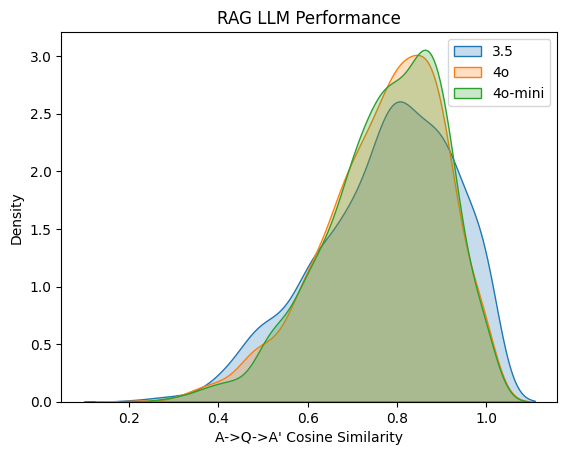

In [91]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.kdeplot(df_gpt35['cosine'], label='3.5', fill=True)
sns.kdeplot(df_gpt4o['cosine'], label='4o', fill=True)
sns.kdeplot(df_gpt_4o_mini['cosine'], label='4o-mini', fill=True)

# Set title and labels
plt.title("RAG LLM Performance")
plt.xlabel("A->Q->A' Cosine Similarity")

# Add legend to the plot
plt.legend()

# Show the plot
plt.show()
